## 1  - Data Exploration

In [1]:
# imports 
import numpy as np
import pandas as pd 
import os
import random
# import tensorflow as tf
import xgboost as xgb

# visualisation'
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style(style = 'darkgrid')
sns.set_palette('viridis')

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

## Reproducibility

In [2]:
# reproducibility 
seed_value = 42
def seeding(seed):
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)
    print('seeding done!')
    
seeding(seed_value)

seeding done!


In [3]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')
gender_submission = pd.read_csv('titanic/gender_submission.csv')

print('Train data')
train.head()

Train data


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# add data from gender_submission
test['Survived'] = gender_submission['Survived']

print('Test data')
test.head()

Test data


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [5]:
print('---Train data---')
print('Data Shape: {:,d} rows X {:d} columns'.format(train.shape[0], train.shape[1]))
print('Total no. of passengers: {:,d}'.format(len(train)))
# print('Number of unique tickets: {:d}'.format(train['Ticket'].nunique()))
print('Number of unique Passenger Classes: {:,d}'.format(train['Pclass'].nunique()))
print('Number of unique Fare amounts: {:,d}'.format(train['Fare'].nunique()))
print()

print('---Test data---')
print('Data Shape: {:,d} rows X {:d} columns'.format(test.shape[0], test.shape[1]))
print('Total no. of passengers: {:,d}'.format(len(test)))
# print('Number of unique tickets: {:,d}'.format(test['Ticket'].nunique()))
print('Number of unique Passenger Classes: {:,d}'.format(test['Pclass'].nunique()))
print('Number of unique Fare amounts: {:,d}'.format(test['Fare'].nunique()))

---Train data---
Data Shape: 891 rows X 12 columns
Total no. of passengers: 891
Number of unique Passenger Classes: 3
Number of unique Fare amounts: 248

---Test data---
Data Shape: 418 rows X 12 columns
Total no. of passengers: 418
Number of unique Passenger Classes: 3
Number of unique Fare amounts: 169


## 1.1 Feature Exploration

Categorical and Continuos Features

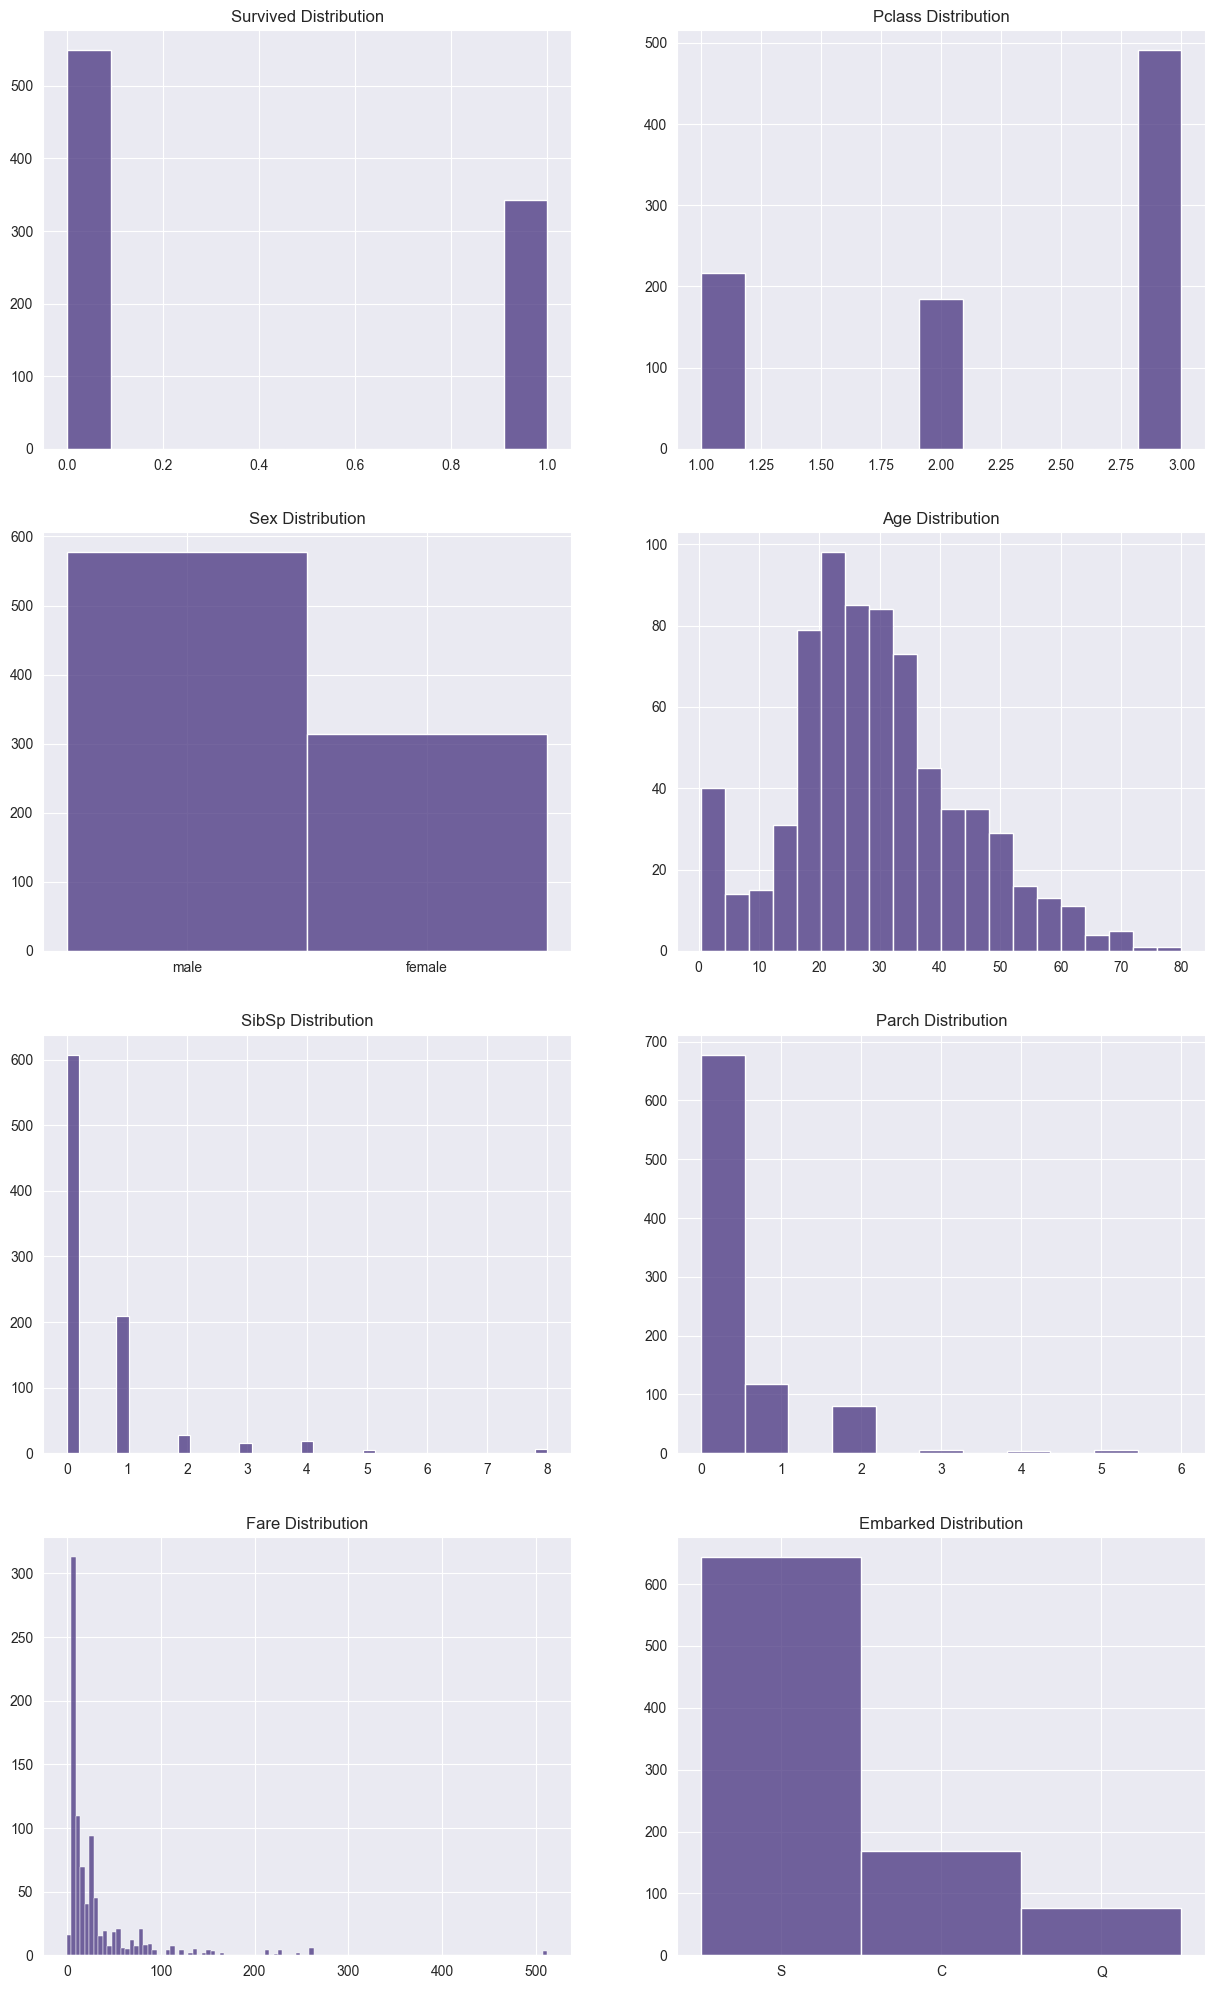

In [6]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize =(15,25))

train_copy = train.copy()
features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
axs = axs.flatten()

for i, feature in enumerate(features):
    _ = sns.histplot(train_copy, x="{}".format(feature), ax=axs[i])
    _ = axs[i].set_title("{} Distribution".format(feature))
    _ = axs[i].set_ylabel("")
    _ = axs[i].set_xlabel("")

## 2 - Missing Data

In [7]:
print('Percentage of missing data per feature in the train set:')
100 * train.isnull().sum() / len(train)

Percentage of missing data per feature in the train set:


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [8]:
print('Percentage of missing data per feature in the test set:')
100 * test.isnull().sum() / len(test)

Percentage of missing data per feature in the test set:


PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
Survived        0.000000
dtype: float64

## 2.1 Age (Train & Test)

In [9]:
features = ["Age"]
train[features].describe().T.style.bar(
    subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,714.000000,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000


C:\Users\bartw\AppData\Local\Temp\ipykernel_6328\4213715170.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = 'Age', data = train, palette = 'flare', bins = 40)


<Axes: xlabel='Age', ylabel='Count'>

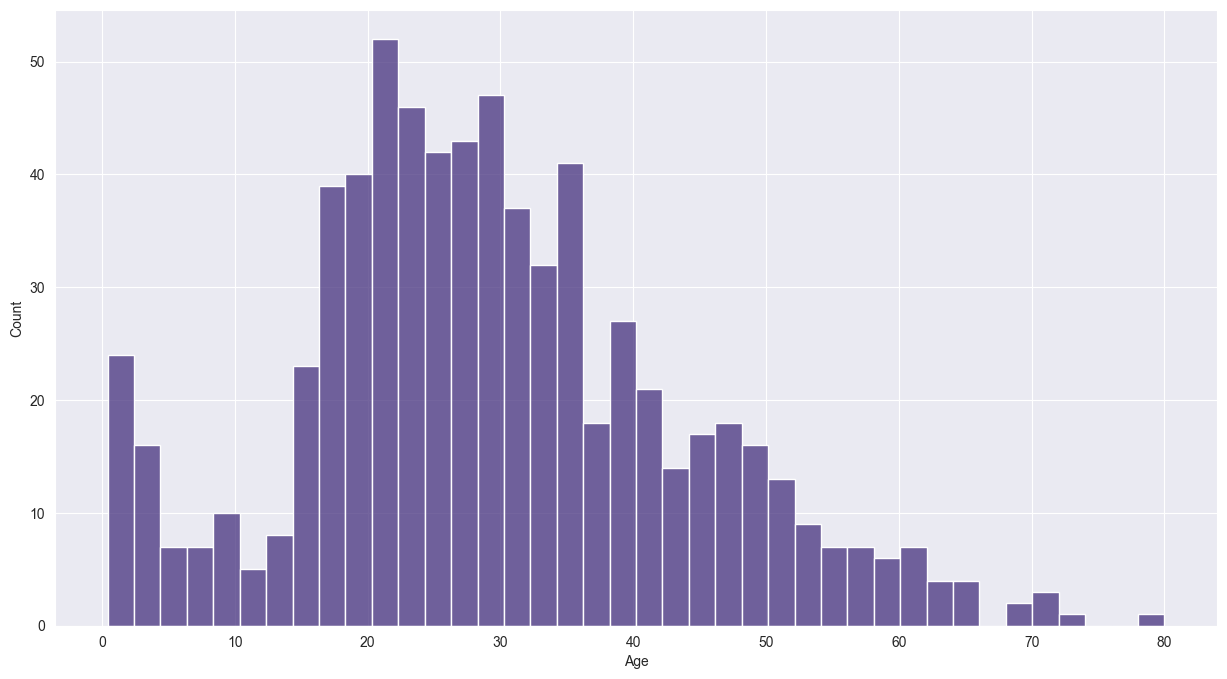

In [10]:
plt.figure(figsize = (15, 8))
sns.histplot(x = 'Age', data = train, palette = 'flare', bins = 40)

In [11]:
print('Age grouped by Pclass:') 
train.groupby('Pclass')['Age'].describe().style.bar(
     subset=['mean'], color = '#7BCC70')\
    .background_gradient(subset = ['std'], cmap = 'flare')\
    .background_gradient(subset = ['50%'], cmap = 'flare') 

Age grouped by Pclass:


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.000000,38.233441,14.802856,0.920000,27.000000,37.000000,49.000000,80.000000
2,173.000000,29.877630,14.001077,0.670000,23.000000,29.000000,36.000000,70.000000
3,355.000000,25.140620,12.495398,0.420000,18.000000,24.000000,32.000000,74.000000


In [12]:
 print('Age grouped by Sex:') 
train.groupby('Sex')['Age'].describe().style.bar(
     subset=['mean'], color = '#7BCC70')\
    .background_gradient(subset = ['std'], cmap = 'flare')\
    .background_gradient(subset = ['50%'], cmap = 'flare') 

Age grouped by Sex:


,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,261.000000,27.915709,14.110146,0.750000,18.000000,27.000000,37.000000,63.000000
male,453.000000,30.726645,14.678201,0.420000,21.000000,29.000000,39.000000,80.000000


In [13]:
# utility 
data_train = train.groupby(['Pclass','Sex'])['Age'].mean()
print("Age grouped by Pclass and Sex in the train data:")
data_train

Age grouped by Pclass and Sex in the train data:


Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [14]:
data_test = test.groupby(['Pclass','Sex'])['Age'].mean()
print("Age grouped by Pclass and Sex in the test data:")
data_test

Age grouped by Pclass and Sex in the test data:


Pclass  Sex   
1       female    41.333333
        male      40.520000
2       female    24.376552
        male      30.940678
3       female    23.073400
        male      24.525104
Name: Age, dtype: float64

In [15]:
# function to fill null age values in the train set
def fill_train_age(pclass, sex, age):
    '''
    takes in the pclass, sex and age 
    if the age is null, then extracts the age from 'data'and returns the corrosponding age
    else returns the original age
    '''
    if np.isnan(age): 
        return data_train.loc[(pclass, sex)]
    else: 
        return age
    
# filling the missing values
train['Age'] = train.apply(lambda x: fill_train_age(x['Pclass'], x['Sex'], x['Age']), axis=1)       

In [16]:
# function to fill null age values in the test set
def fill_test_age(pclass, sex, age):
    '''
    takes in the pclass, sex and age 
    if the age is null, then extracts the age from 'data'and returns the corrosponding age
    else returns the original age
    '''
    if np.isnan(age): 
        return data_test.loc[(pclass, sex)]
    else: 
        return age

# filling the missing values
test['Age'] = test.apply(lambda x: fill_test_age(x['Pclass'], x['Sex'], x['Age']), axis=1)            

## 2.2 Fare (Test only)

In [17]:
# function to fill missing fare in test dataset
def fill_fare(fare):
    '''
    takes in fare if null
    returns the most common value
    '''
  
    if np.isnan(fare):
        return round(test['Fare']).value_counts().max()
    else:
        return fare
    
test['Fare'] = test.apply(lambda x: fill_fare(x['Fare']), axis=1)  

## 2.3 Embarked (Train only)

In [18]:
# storing the most common 'Embarked' value
common_value = train['Embarked'].value_counts().idxmax()

In [19]:
# filling all null values
train['Embarked'] =train['Embarked'].fillna(common_value)

In [20]:
# check
train['Embarked'].isnull().sum()

0

## 2.4 Cabin (Train & Test)

Turns out, the first letter of the Cabin signifies the decks on which the cabins are located. Let's first explore this furthur

In [21]:
train['Deck'] = train['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'M')
test['Deck'] = test['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'M')

In [22]:
print('Train data grouped by Deck and Pclass:')
train.groupby(['Deck', 'Pclass']).size().reset_index(name = 'Counts')


Train data grouped by Deck and Pclass:


,Deck,Pclass,Counts
0,A,1,15
1,B,1,47
2,C,1,59
3,D,1,29
4,D,2,4
5,E,1,25
6,E,2,4
7,E,3,3
8,F,2,8
9,F,3,5


In [23]:
print('Test data grouped by Deck and Pclass:')
test.groupby(['Deck', 'Pclass']).size().reset_index(name = 'Counts')

Test data grouped by Deck and Pclass:


,Deck,Pclass,Counts
0,A,1,7
1,B,1,18
2,C,1,35
3,D,1,11
4,D,2,2
5,E,1,9
6,F,2,5
7,F,3,3
8,G,3,1
9,M,1,27


In [24]:
train['Deck'] = train['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC')
train['Deck'] = train['Deck'].replace(['D', 'E'], 'DE')
train['Deck'] = train['Deck'].replace(['F', 'G'], 'FG')

test['Deck'] = test['Deck'].replace(['A', 'B', 'C'], 'ABC')
test['Deck'] = test['Deck'].replace(['D', 'E'], 'DE')
test['Deck'] = test['Deck'].replace(['F', 'G'], 'FG')

## 3  - Feature Engineering

## 3.1 Extracting titles from 'Name' 
We cannot use the whole name as there are a lot of unique names. But all the names have a title that is associated with the person. We can extract the titles and convert them into dummies.


In [25]:
# storing the most common titles 
titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Other', 'Mlle', 'Ms', 'Mme']

In [26]:
# function to extract the tile 
def extract_title(name):
    '''
    takes in the name feature
    splits the name based on space and creates a list 
    stores in the 2nd item (title) in the variable 'title'
    
    if the title is not among the common titles, returns 'Other'
    else returns the title 
    '''

    title = name.split('.')[0].split(' ')[-1]
    
    if title not in titles:
        return titles[4]
    else:
        return title


In [27]:
# extracting the title in a different coulmn
train['Title'] = train.apply(lambda x: extract_title(x['Name']), axis=1)
test['Title'] = test.apply(lambda x: extract_title(x['Name']), axis=1)  

In [28]:
# replacing 
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

# replacing 
test['Title'] = test['Title'].replace('Ms', 'Miss')

## 3.2 Fam size

<Figure size 900x500 with 0 Axes>

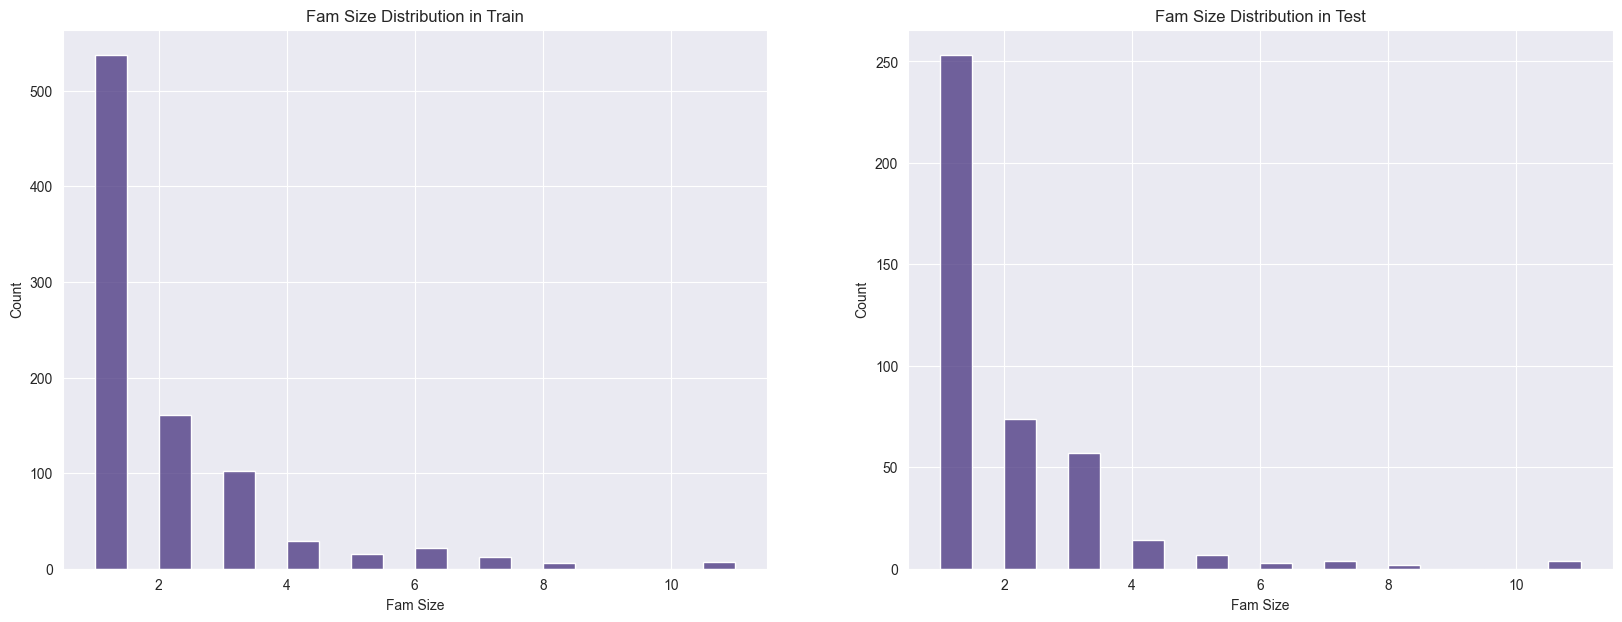

In [29]:
train['Fam Size'] = train['SibSp'] + train['Parch'] + 1
test['Fam Size'] = test['SibSp'] + test['Parch'] + 1

plt.figure(figsize = (9, 5))
fig, axs = plt.subplots(ncols = 2, figsize =(20, 7))

sns.histplot(x = 'Fam Size', data = train, ax = axs[0], binwidth= 0.5)
_ = axs[0].set_title("Fam Size Distribution in Train")

sns.histplot(x = 'Fam Size', data = test, ax = axs[1], binwidth= 0.5)
_ = axs[1].set_title("Fam Size Distribution in Test")

In [30]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}

train['Fam Size grouped'] = train['Fam Size'].map(family_map)
test['Fam Size grouped'] = test['Fam Size'].map(family_map)

<Figure size 900x500 with 0 Axes>

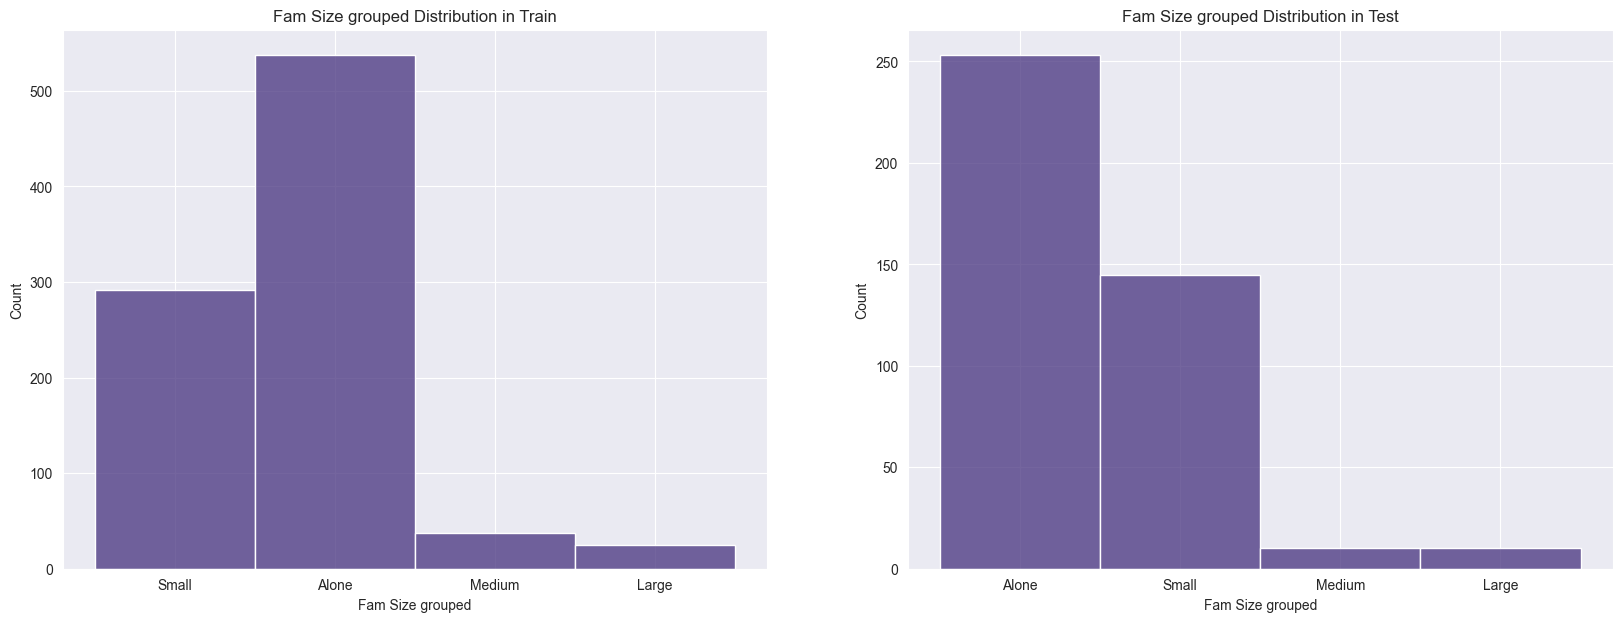

In [31]:
plt.figure(figsize = (9, 5))
fig, axs = plt.subplots(ncols = 2, figsize =(20, 7))

sns.histplot(x = 'Fam Size grouped', data = train, ax = axs[0], binwidth= 0.5)
_ = axs[0].set_title("Fam Size grouped Distribution in Train")

sns.histplot(x = 'Fam Size grouped', data = test, ax = axs[1], binwidth= 0.5)
_ = axs[1].set_title("Fam Size grouped Distribution in Test")

## 3.3 Age 

In [32]:
bins = [0,10, 20, 30, 40, 50, 60, 80]
labels=['babies','teens','20s', '30s','40s','50s','oldge']

train['Age group'] = pd.cut(train['Age'], bins, labels=labels)
test['Age group'] = pd.cut(test['Age'], bins, labels=labels)

age_map = {'babies': 1, 'teens': 2, '20s': 3, '30s': 4, '40s': 5, '50s': 6, 'oldge': 7}
train['Age group'] = pd.to_numeric(train['Age group'].map(age_map))
test['Age group'] = pd.to_numeric(test['Age group'].map(age_map))

## 3.4 Fare

In [33]:
train['Fare'] = pd.qcut(train['Fare'], 13)
test['Fare'] = pd.qcut(test['Fare'], 13)

<Figure size 900x2000 with 0 Axes>

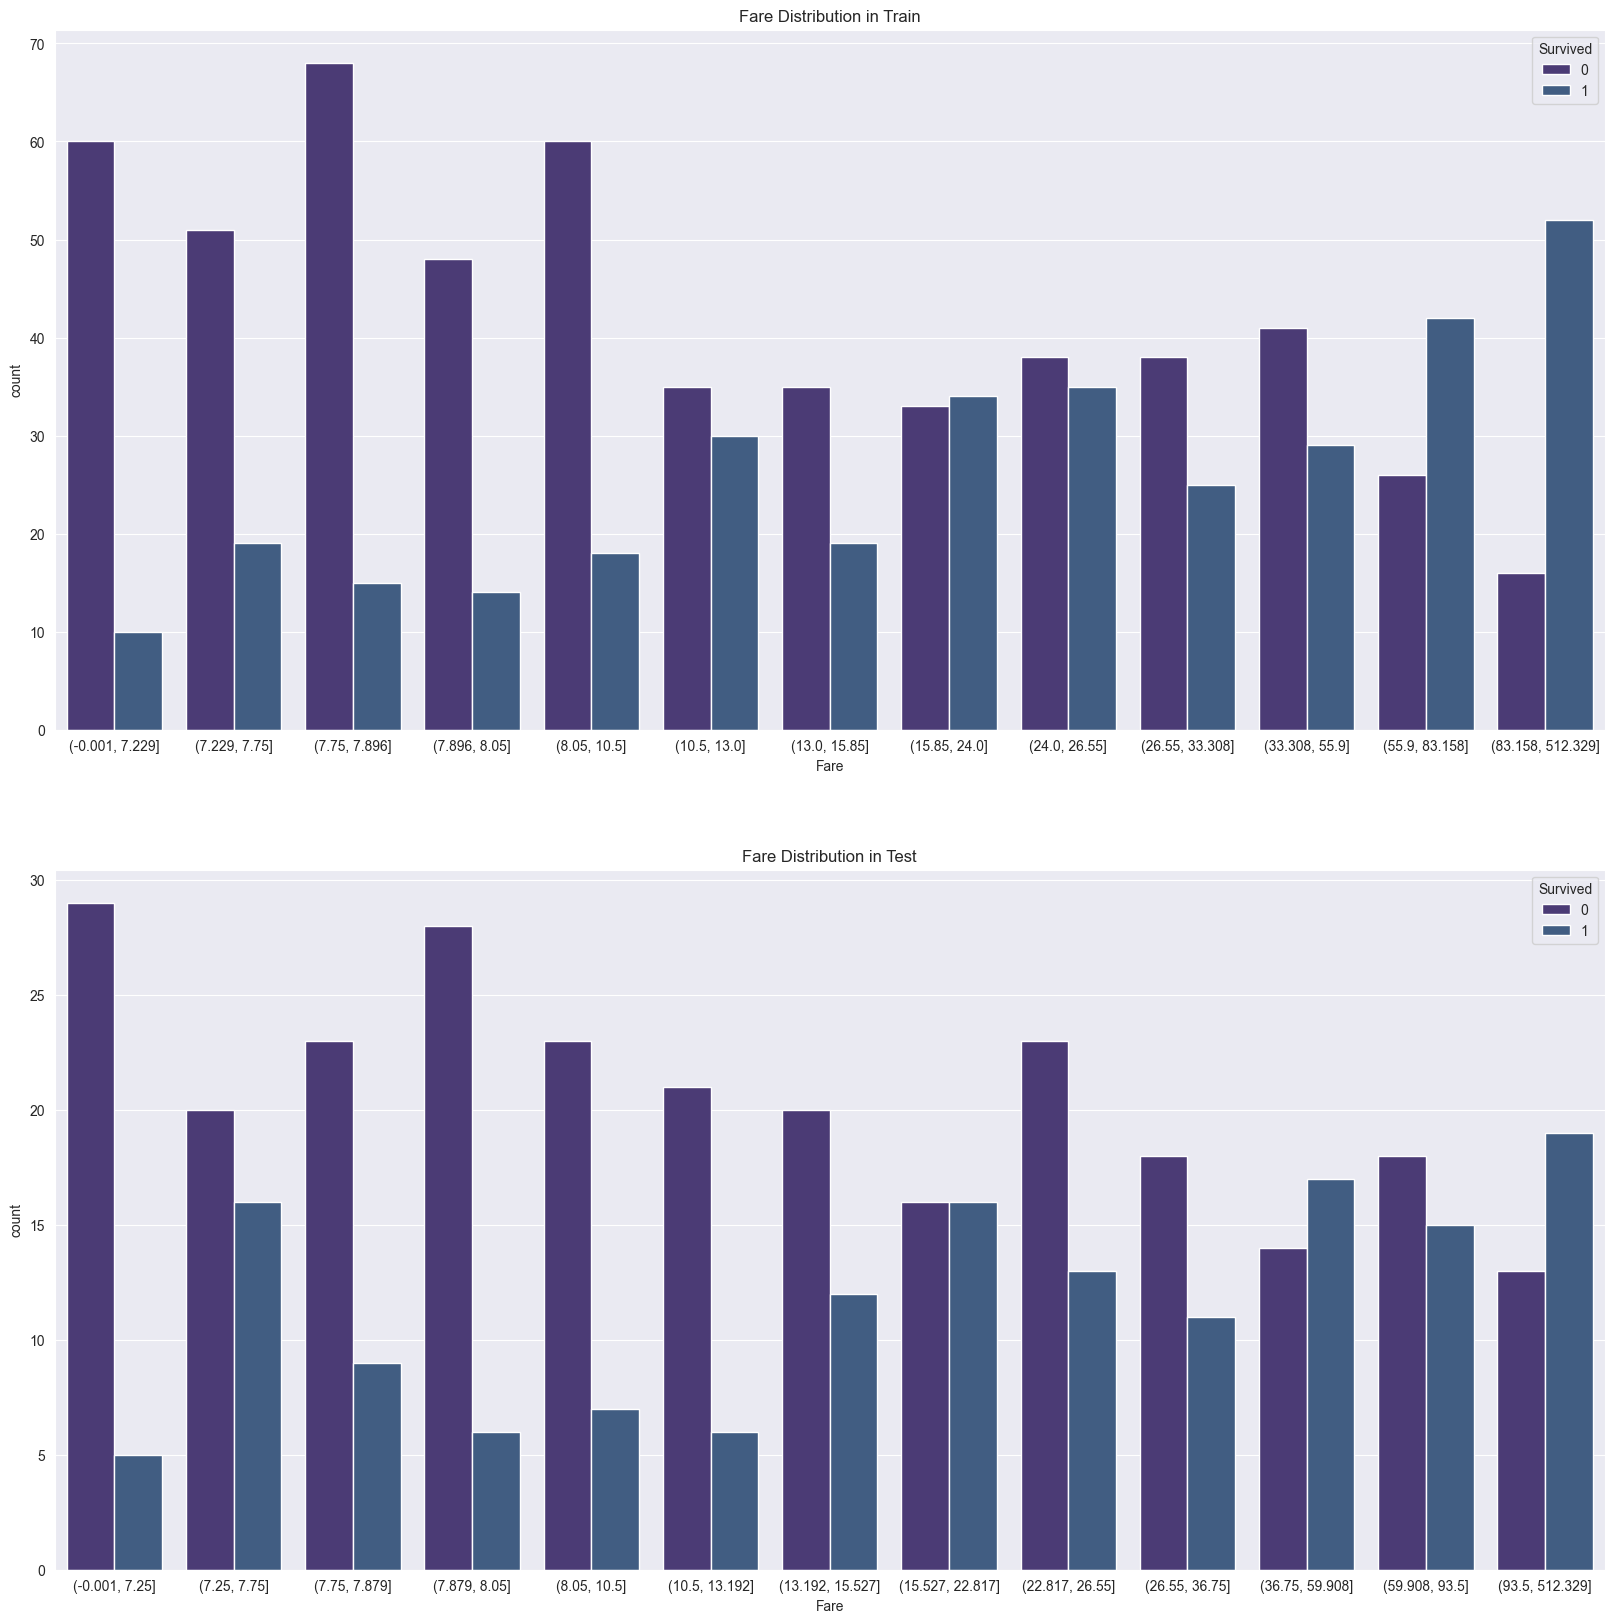

In [34]:
plt.figure(figsize = (9, 20))
fig, axs = plt.subplots(nrows = 2, figsize = (20,20))

sns.countplot(x = 'Fare', data = train, hue = 'Survived', ax = axs[0])
_ = axs[0].set_title("Fare Distribution in Train")

sns.countplot(x = 'Fare', data = test, hue = 'Survived', ax = axs[1])
_ = axs[1].set_title("Fare Distribution in Test")

In [35]:
train['Ticket_Frequency'] = train.groupby('Ticket')['Ticket'].transform('count')
test['Ticket_Frequency'] = test.groupby('Ticket')['Ticket'].transform('count')

## 4 - Data Processing

* Dropping columns that are not useful
* Label encoding
* One hot encoding
* Scaling 
* Data Split

## 4.1 Dropping Unhelpful Data

In [36]:
# dropping columns that are not helpful
train_df = train.drop(['Name', 'PassengerId','Age', 'SibSp', 'Parch', 'Cabin', 'Fam Size', 'Ticket'], axis = 1)
test_df = test.drop(['Name', 'Age', 'SibSp', 'Parch', 'Cabin', 'Fam Size', 'Ticket'], axis = 1)

In [37]:
train_df.head(0)

,Survived,Pclass,Sex,Fare,Embarked,Deck,Title,Fam Size grouped,Age group,Ticket_Frequency


In [38]:
test_df.head(0)

,PassengerId,Pclass,Sex,Fare,Embarked,Survived,Deck,Title,Fam Size grouped,Age group,Ticket_Frequency


## 4.2 Label encoding

In [39]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
non_numeric_features = ['Embarked', 'Fare', 'Sex', 'Deck', 'Title', 'Fam Size grouped', 'Age group']

for feature in non_numeric_features:        
    train[feature] = LabelEncoder().fit_transform(train[feature])
print('Encoding for train finished!')
        
for feature in non_numeric_features:        
    test[feature] = LabelEncoder().fit_transform(test[feature])
print('Encoding for test finished!')

Encoding for train finished!
Encoding for test finished!


## 4.3 One Hot Encoding

In [40]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Fam Size grouped']
encoded_features = []

for feature in cat_features:
    encoded_feat = OneHotEncoder().fit_transform(train_df[feature].values.reshape(-1, 1)).toarray()
    n = train_df[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = train_df.index
    encoded_features.append(encoded_df)
    
train_df = pd.concat([train_df, *encoded_features[:6]], axis=1)

In [41]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Fam Size grouped']
encoded_features = []

for feature in cat_features:
    encoded_feat = OneHotEncoder(handle_unknown='ignore').fit_transform(test_df[feature].values.reshape(-1, 1)).toarray()
    n = test_df[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = test_df.index
    encoded_features.append(encoded_df)
    
test_df = pd.concat([test_df, *encoded_features[:6]], axis=1)

In [42]:
# change dtype for Fare for scaling
train_df['Fare'] = train_df['Fare'].apply(lambda x: x.mid).astype(float)
test_df['Fare'] = test_df['Fare'].apply(lambda x: x.mid).astype(float)

In [43]:
drop_cols = ['Sex', 'Embarked', 'Deck', 'Title', 'Fam Size grouped','Pclass']

train_df = train_df.drop(columns = drop_cols)
test_df = test_df.drop(columns = drop_cols)

## 4.4 Labels

In [44]:
# define the labels
X_train = train_df.drop(['Survived'], axis = 1)
y_train = train_df['Survived'].values

X_test = test_df.drop(['PassengerId', 'Survived'], axis = 1)
y_test = test_df['Survived']

In [45]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 24)
y_train shape: (891,)
X_test shape: (418, 24)


In [46]:
# utility
train_columns = X_train.columns

## 4.5 Scaling

In [47]:
# import 
from sklearn.preprocessing import StandardScaler

# creating an instance of the scaler
scaler = StandardScaler()

# using .fit_transform() on the train and val data
X_train = scaler.fit_transform(X_train)

# using only fit for the test data for no leaks
X_test = scaler.transform(X_test)

## 4.6 Data Split

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = seed_value)

## 5 - Model

* Creating a Random Forest Classifier
* Get the best estimator via GridSearch
* Re-train with the best estimator
* Cross Validation
* Feature Importance
* Submission

## 5.1 Model 

The `StratifiedKfold` val paired with `N_estimators` and `max_depth` had majority of impact in bumping the `val_score` from 0.79 to 0.83

In [51]:
clf = RandomForestClassifier(n_estimators = 1170, 
                             oob_score = True,
                             max_depth = 7, # makes the most difference  
                             min_samples_split=6, 
                             min_samples_leaf=6,
                             random_state = seed_value, 
                             verbose = 1)

## 5.2 StratifiedKFold

In [52]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=train_columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=seed_value, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    clf.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], clf.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], clf.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = clf.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = clf.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = clf.feature_importances_
        
    oob += clf.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, clf.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Fold 1 OOB Score: 0.8400702987697716

Fold 2



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Fold 2 OOB Score: 0.8172231985940246

Fold 3



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Fold 3 OOB Score: 0.8315789473684211

Fold 4



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

Fold 4 OOB Score: 0.8315789473684211

Fold 5



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


Fold 5 OOB Score: 0.8333333333333334

Average OOB Score: 0.8307569450867942


[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


## 5.3 Feature Importance

In [53]:
importances = pd.DataFrame({'feature':train_columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

print('Feature Importance:')
importances

Feature Importance:


,importance
feature,
Title_3,0.189
Sex_1,0.163
Sex_2,0.159
Pclass_3,0.063
Title_4,0.056
Fare,0.054
Ticket_Frequency,0.047
Title_2,0.045
Age group,0.035


<Axes: xlabel='feature'>

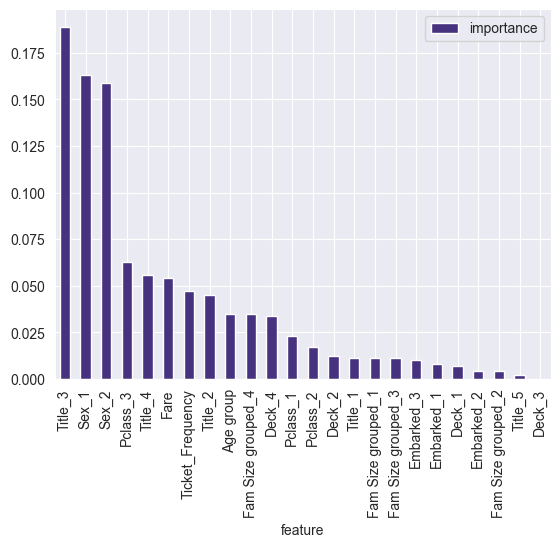

In [54]:
importances.plot.bar()

## 5.4 Evaluation

In [55]:
predictions = clf.predict(X_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


Please note that the value for the y-test used here is extracted from the `gender_submission.csv` provided in the [data](https://www.kaggle.com/competitions/titanic/data) section of this competition.
The predictions made in `gender_submission.csv` are made by assuming that only the female passengers survive. I added these just for a quick comparison with the predictions provided by the competition. 
Kindly only take the cross_validation accuracy as the true estimate of the model's accuracy. You can also get the accuracy from sklearn's in-built accuracy function. 

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print('Classification Report:')
print()
print(classification_report(y_test, predictions))

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       266
           1       0.92      0.88      0.90       152

    accuracy                           0.93       418
   macro avg       0.93      0.92      0.92       418
weighted avg       0.93      0.93      0.93       418



Confusion Matrix:



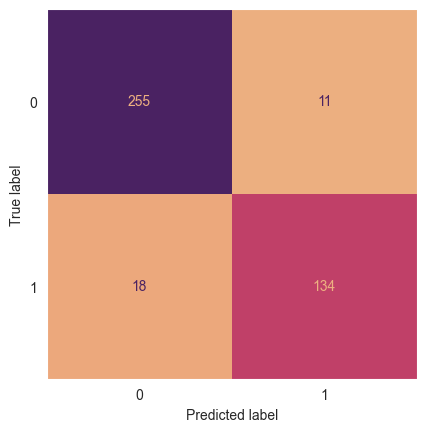

In [57]:
print('Confusion Matrix:')
print()
ConfusionMatrixDisplay.from_predictions(y_test, predictions, colorbar = False, cmap = 'flare')
plt.grid(False)

## 5.5 Submission

In [58]:
submission = pd.DataFrame(predictions, columns = ['Survived'])
submission = pd.concat([test['PassengerId'], submission], axis = 1)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [59]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [60]:
submission['Survived'].value_counts()

Survived
0    273
1    145
Name: count, dtype: int64

In [61]:
submission = submission.to_csv('kaggle_titanic.csv',index=False)

## 5.6 References

The params for the clf, Stratified kfold val and a lil bit of feature engineering was implemented/taken from [this notebook](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial) 